# Problem 2, Parts A-B: Boosted Decision Tree

In this Jupyter notebook, we will train a boosted decision tree on the MiniBooNE dataset.

Use this notebook to write your code for problem 1 parts A-B by filling in the sections marked `# TODO` and running all cells.

In [47]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt



data = fetch_openml("miniboone", parser="auto", version=1)
X, y = data["data"].values, (data["target"].values == "True").astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [48]:
from xgboost import XGBClassifier

n_estimators = 100
max_depth = 10
learning_rate = 0.1
colsample_bytree = 0.8
subsample = 0.8

bdt = XGBClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    learning_rate=learning_rate,
    colsample_bytree=colsample_bytree,
    subsample=subsample,
    eval_metric="logloss",
    random_state=42
)

bdt.fit(X_train, y_train)

preds_bdt = bdt.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, preds_bdt)
roc_auc = auc(fpr, tpr)

preds_bdt = bdt.predict_proba(X_test)[:, 1]
y_pred_labels = (preds_bdt > 0.5).astype(int)
acc = accuracy_score(y_test, y_pred_labels)

# Print results
print(f"AUC: {roc_auc:.4f}")
print(f"Accuracy: {acc:.4f}")


AUC: 0.9856
Accuracy: 0.9465


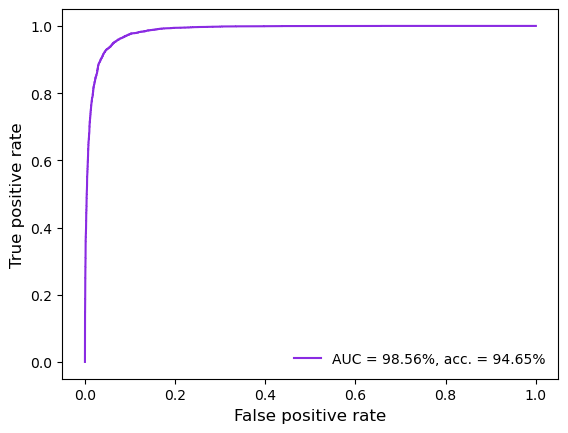

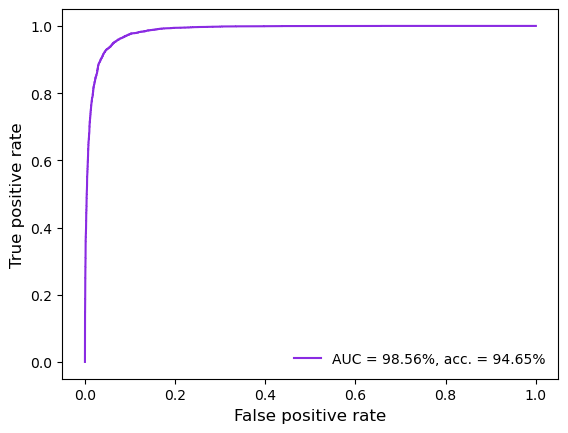

In [49]:
from roc_helper import plot_roc

plot_roc(y_test, preds_bdt)

<Figure size 800x600 with 0 Axes>

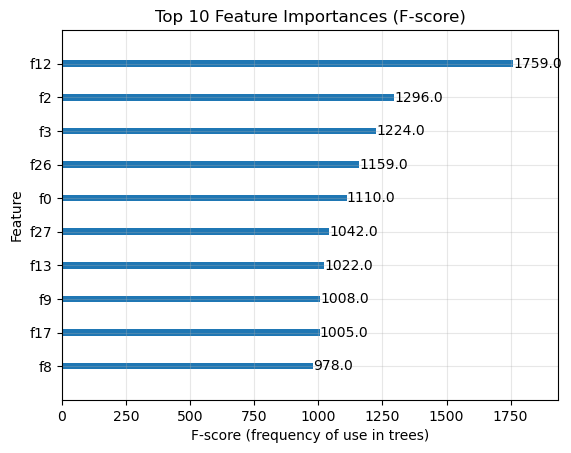

Most important feature: f12


In [50]:
import xgboost as xgb

plt.figure(figsize=(8, 6))
xgb.plot_importance(bdt, max_num_features=10, importance_type='weight')
plt.title("Top 10 Feature Importances (F-score)")
plt.xlabel("F-score (frequency of use in trees)")
plt.ylabel("Feature")
plt.grid(True, alpha=0.3)
plt.savefig("../images/top_10_feature_importances.png")
plt.show()

booster = bdt.get_booster()
importance_dict = booster.get_score(importance_type='weight')
most_important_feature = max(importance_dict, key=importance_dict.get)
print("Most important feature:", most_important_feature)

In [51]:
fi = int(most_important_feature.strip('f'))
vals = X_test[:, fi]
print("min, p1, p50, p99, max =", 
      np.min(vals), np.percentile(vals,1), np.median(vals), np.percentile(vals,99), np.max(vals))
print("fraction exactly 0:", np.mean(vals == 0))



min, p1, p50, p99, max = -999.0 -0.9618165599999999 0.631776 0.99760324 1.0
fraction exactly 0: 0.0


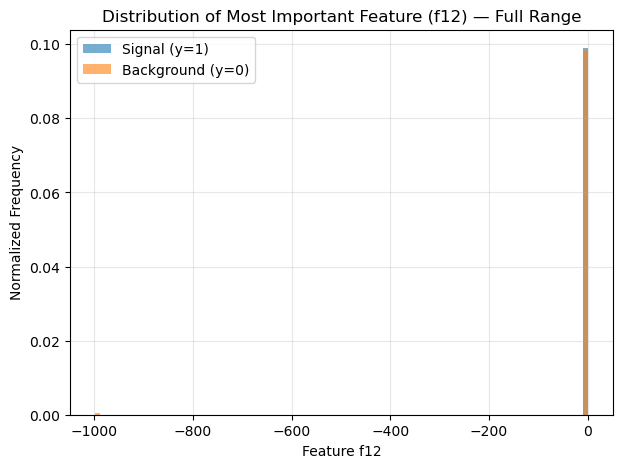

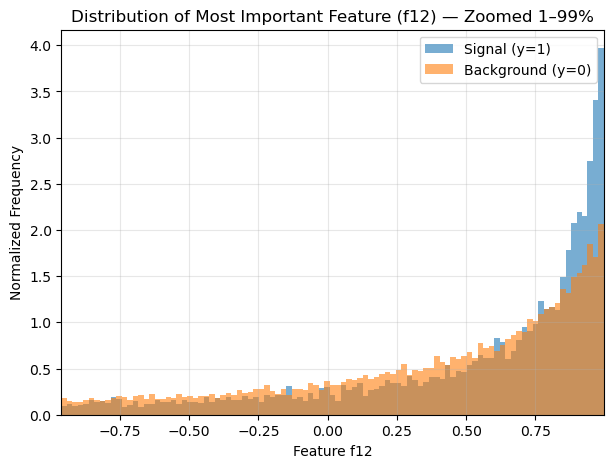

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

feature_index = int(most_important_feature.strip('f'))  # 'f0' -> 0, etc.
feature_vals = X_test[:, feature_index]
signal_vals = feature_vals[y_test == 1]
background_vals = feature_vals[y_test == 0]

# ==============================================
# Plot histograms for signal vs background
# ==============================================

bins_full = np.linspace(vals.min(), vals.max(), 100)
sig = vals[y_test == 1]
bkg = vals[y_test == 0]

plt.figure(figsize=(7,5))
plt.hist(sig, bins=bins_full, density=True, alpha=0.6, label="Signal (y=1)")
plt.hist(bkg, bins=bins_full, density=True, alpha=0.6, label="Background (y=0)")
plt.xlabel(f"Feature {most_important_feature}")
plt.ylabel("Normalized Frequency")
plt.title(f"Distribution of Most Important Feature ({most_important_feature}) — Full Range")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("../images/feature_distribution_full.png")
plt.show()

lo, hi = np.percentile(vals, 1), np.percentile(vals, 99)  
bins_zoom = np.linspace(lo, hi, 100)

plt.figure(figsize=(7,5))
plt.hist(sig, bins=bins_zoom, density=True, alpha=0.6, label="Signal (y=1)")
plt.hist(bkg, bins=bins_zoom, density=True, alpha=0.6, label="Background (y=0)")
plt.xlabel(f"Feature {most_important_feature}")
plt.ylabel("Normalized Frequency")
plt.title(f"Distribution of Most Important Feature ({most_important_feature}) — Zoomed 1–99%")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(lo, hi)
plt.savefig("../images/feature_distribution_zoomed.png")
plt.show()
